In [2]:
# Importing necessary libraries
import pandas as pd  # Data manipulation and analysis
import random  # Random number generation
from sklearn.model_selection import train_test_split  # For splitting dataset into training and test sets
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments  # Transformers library for natural language processing (NLP) models
import torch  # PyTorch library for deep learning tasks
from sklearn.metrics import accuracy_score, f1_score  # For evaluating model performance

# Define templates for each risk tolerance level
templates = {
    1: [
        "I am extremely uncomfortable with any losses.",
        "I prefer stable, low-risk assets.",
        "I would panic and sell everything.",
        "Yes, I prefer consistent returns.",
        "I rely heavily on professional advice.",
        "High-risk investments are not for me.",
        "I want steady, long-term growth.",
        "I avoid downturns whenever possible.",
        "I never invest in speculative industries.",
        "I diversify my portfolio extensively."
    ],
    2: [
        "I can tolerate small financial losses.",
        "I prefer low to moderate risk investments.",
        "I would feel anxious but hold on during a 10% drop.",
        "I prefer consistent returns but consider small risks.",
        "I value professional advice but make some decisions independently.",
        "I rarely invest in high-risk opportunities.",
        "I aim for long-term growth with minimal risk.",
        "I avoid major downturns but sometimes look for opportunities.",
        "I invest in speculative markets occasionally with caution.",
        "I focus on diversification to reduce risk."
    ],
    3: [
        "I accept some losses in exchange for moderate returns.",
        "I invest in a mix of stable and growth assets.",
        "I would monitor and hold during a 10% drop.",
        "I aim for moderate returns with acceptable risks.",
        "I consult professionals but also trust my judgment.",
        "I invest in high-risk stocks occasionally.",
        "I want balanced growth and risk.",
        "I see downturns as moderate opportunities.",
        "I sometimes invest in emerging industries.",
        "I moderately diversify my portfolio."
    ],
    4: [
        "I accept significant losses for high returns.",
        "I frequently invest in growth-focused, volatile stocks.",
        "I stay confident during market downturns.",
        "I prioritize growth over stability.",
        "I rarely rely on professional advice.",
        "I enjoy seeking high-risk investments.",
        "I aim for aggressive growth in my portfolio.",
        "I actively buy assets during downturns.",
        "I often invest in speculative or emerging industries.",
        "I diversify selectively for maximum returns."
    ],
    5: [
        "I embrace the possibility of significant losses.",
        "I thrive on high-risk, high-reward opportunities.",
        "I see losses as temporary and ignore them.",
        "I always prioritize the highest possible gains.",
        "I make my own investment decisions without advice.",
        "I consistently seek out high-risk investments.",
        "I want to maximize returns as quickly as possible.",
        "I consider downturns as major buying opportunities.",
        "I frequently invest in speculative industries.",
        "I focus on minimal diversification for maximum growth."
    ]
}

# Generate a dataset of 200 investors with their responses to questions based on their risk tolerance
num_investors = 200  # Increased dataset size for more variety in risk tolerance
data = []

# Loop through each investor and generate their responses based on a random risk tolerance level (1-5)
for investor_id in range(1, num_investors + 1):
    risk_level = random.randint(1, 5)  # Randomly assign a risk level (1 to 5)
    responses = random.sample(templates[risk_level], 10)  # Randomly sample 10 responses from the templates for this risk level
    data.append([investor_id] + responses + [risk_level])  # Append the investor data to the list

# Convert the generated data into a DataFrame for easier handling
columns = ['Investor ID'] + [f"Q{i}" for i in range(1, 11)] + ['Risk Tolerance Label']
df = pd.DataFrame(data, columns=columns)

# Split the data into features (X) and labels (y), then into training and testing sets
X = df[[f"Q{i}" for i in range(1, 11)]].values  # Features are the answers to the 10 questions
y = df['Risk Tolerance Label'].values  # Labels are the risk tolerance levels (1-5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)  # Split into 90% training and 10% test

# Load the DistilBERT tokenizer for tokenizing the input text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to encode examples (tokenize the questions and answers for training)
def encode_examples(examples):
    return tokenizer(examples, padding=True, truncation=True, max_length=128, return_tensors="pt")  # Tokenize with padding and truncation

# Apply the encoding function to the training and test data
train_encodings = encode_examples([' '.join(row) for row in X_train])
test_encodings = encode_examples([' '.join(row) for row in X_test])

# Create a custom Dataset class for PyTorch to handle the tokenized data
class RiskToleranceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Store the tokenized data
        self.labels = labels  # Store the labels (risk tolerance levels)

    # This method allows PyTorch to fetch a sample (data point) for training
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Convert tokenized data to tensors
        item['labels'] = torch.tensor(self.labels[idx] - 1)  # Adjust labels to be 0-indexed
        return item

    def __len__(self):
        return len(self.labels)

# Instantiate the training and testing datasets
train_dataset = RiskToleranceDataset(train_encodings, y_train)
test_dataset = RiskToleranceDataset(test_encodings, y_test)

# Load the pre-trained DistilBERT model for sequence classification (for NLP tasks)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)  # We have 5 risk levels (labels)

# Define the training arguments (parameters that control training behavior)
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save model checkpoints
    evaluation_strategy="epoch",  # Evaluate model after each epoch
    learning_rate=2e-5,  # Set a lower learning rate to improve convergence
    per_device_train_batch_size=16,  # Set batch size for training
    per_device_eval_batch_size=16,  # Set batch size for evaluation
    num_train_epochs=10,  # Limit number of training epochs to avoid overfitting
    weight_decay=0.01,  # Regularization to prevent overfitting
    logging_dir="./logs",  # Directory to save logs
    logging_steps=10,  # Log after every 10 steps
    save_strategy="epoch",  # Save model at the end of each epoch
    save_total_limit=2,  # Limit the number of saved models
    load_best_model_at_end=True,  # Always load the best model after training
    metric_for_best_model="accuracy",  # Select the model with the best accuracy as the best model
)

# Function to compute evaluation metrics (accuracy and F1 score)
def compute_metrics(pred):
    logits, labels = pred  # Get predictions and labels
    predictions = torch.argmax(torch.tensor(logits), dim=-1)  # Get the predicted class by selecting the highest score
    acc = accuracy_score(labels, predictions)  # Compute accuracy
    f1 = f1_score(labels, predictions, average="weighted")  # Compute weighted F1 score
    return {"accuracy": acc, "f1": f1}  # Return metrics as a dictionary

# Instantiate the Trainer with all the necessary components
trainer = Trainer(
    model=model,  # Model to train
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=test_dataset,  # Evaluation dataset
    tokenizer=tokenizer,  # Tokenizer for preprocessing
    compute_metrics=compute_metrics  # Metrics function to evaluate the model's performance
)

# Train the model using the Trainer
trainer.train()

# Save the trained model to disk for future use
trainer.save_model("./distilbert_risk_tolerance_model")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/mv/r40czkk56nb26qqgg0gmjjpr0000gn/T/ipykernel_5540/1474585926.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/var/folders/mv/r40czkk56nb26qqgg0gmjjpr0000gn/T/ipykernel_5540/1474585926.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().det

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.558700,1.359147,0.650000,0.558788
2,1.296200,0.874398,1.000000,1.000000
3,0.892700,0.509815,1.000000,1.000000
4,0.589800,0.304553,1.000000,1.000000
5,0.271000,0.200978,1.000000,1.000000
6,0.202900,0.142606,1.000000,1.000000
7,0.158500,0.113353,1.000000,1.000000
8,0.129600,0.096397,1.000000,1.000000
9,0.120200,0.087548,1.000000,1.000000
10,0.103000,0.085360,1.000000,1.000000


/var/folders/mv/r40czkk56nb26qqgg0gmjjpr0000gn/T/ipykernel_5540/1474585926.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Convert tokenized data to tensors
/var/folders/mv/r40czkk56nb26qqgg0gmjjpr0000gn/T/ipykernel_5540/1474585926.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}  # Convert tokenized data to tensors
/var/folders/mv/r40czkk56nb26qqgg0gmjjpr0000gn/T/ipykernel_5540/1474585926.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta

In [3]:
x = f""" Training Loss: 0.10 | Validation Loss: 0.08 | Accuracy: 100% | F1 Score: 1.00"""
x


' Training Loss: 0.10 | Validation Loss: 0.08 | Accuracy: 100% | F1 Score: 1.00'

In [4]:
print("Key Observations:")
print("The model shows perfect accuracy and F1 scores by epoch 10, indicating strong performance on both training and validation data.")
print("The consistent decrease in validation loss suggests the model is effectively learning and generalizing.")
print("However, the model appears to be overfitting after epoch 1, as the accuracy and F1 score remain at 100% for the remainder of the epochs.")
print("Consider adjusting the number of epochs, adding regularization, or implementing early stopping to prevent overfitting.")


Key Observations:
The model shows perfect accuracy and F1 scores by epoch 10, indicating strong performance on both training and validation data.
The consistent decrease in validation loss suggests the model is effectively learning and generalizing.
However, the model appears to be overfitting after epoch 1, as the accuracy and F1 score remain at 100% for the remainder of the epochs.
Consider adjusting the number of epochs, adding regularization, or implementing early stopping to prevent overfitting.


In [5]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline

# Load pre-trained model for sentiment analysis or risk classification
tokenizer = DistilBertTokenizer.from_pretrained('./distilbert_risk_tolerance_model')
model = DistilBertForSequenceClassification.from_pretrained('./distilbert_risk_tolerance_model', num_labels=5)

# Function to tokenize and get the sentiment classification
def classify_risk_tolerance(response):
    # Tokenize the user response
    inputs = tokenizer(response, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predicted class (Risk Tolerance Level from 0 to 4)
    predictions = torch.argmax(outputs.logits, dim=1)
    
    return predictions.item()


In [6]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Questions for the NLP chatbot
questions = [
    "How do you feel about losing money in an investment?",
    "How do you view market fluctuations?",
    "How much risk are you willing to take for potentially higher returns?",
    "How do you handle a sudden market downturn?",
    "How much do you trust your own judgment versus professional advice?"
]

# Enhanced risk scoring function
def classify_risk_tolerance(response):
    # Analyze sentiment
    sentiment = sentiment_analyzer(response)[0]
    polarity = sentiment['label']
    response_lower = response.lower()
    
    # Keyword-based semantic analysis
    keywords = {
        1: ["don't want to lose", "avoid risk", "hate losing", "no risk", "cautious", "low"],
        3: ["some risk", "moderate", "acceptable risk", "balanced"],
        5: ["high risk", "maximum", "volatility", "handle", "calm", "confident"]
    }
    
    # Assign score based on keywords
    for score, phrases in keywords.items():
        if any(phrase in response_lower for phrase in phrases):
            return score
    
    # Fallback to sentiment polarity
    if polarity == "NEGATIVE":
        return 1
    elif polarity == "NEUTRAL":
        return 3
    else:  # POSITIVE
        return 5

# Function to calculate risk level based on total score
def calculate_risk_level(total_score):
    # Ensure the score is within the expected range
    assert 0 <= total_score <= 25, "Error: Total score is out of range (0-25)."
    
    # Define risk tolerance levels
    if total_score <= 9:
        return "Risk-averse (Level 1)"
    elif 10 <= total_score <= 14:
        return "Low Risk Tolerance (Level 2)"
    elif 15 <= total_score <= 19:
        return "Moderate Risk Tolerance (Level 3)"
    elif 20 <= total_score <= 24:
        return "High Risk Tolerance (Level 4)"
    else:  # total_score == 25
        return "Very High Risk Tolerance (Level 5)"


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [7]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load transformer pipelines and models
sentiment_analyzer = pipeline("sentiment-analysis")
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight sentence transformer

# Predefined keyword combinations for each risk score
keywords = {
    1: [
        "I don't want to lose money", "avoid risk at all costs", "I hate losing money", 
        "I prefer stability over returns", "no risk is acceptable", "low-risk investments only", 
        "I am very cautious about investments", "I don't like market fluctuations", 
        "minimize losses", "I prefer guaranteed returns", "I avoid high-risk ventures", 
        "my priority is capital preservation", "I prefer bonds or fixed deposits", 
        "I am uncomfortable with volatility", "safety over growth", "I have zero risk tolerance", 
        "I need certainty in investments", "I dislike uncertainty", "I avoid stocks", 
        "I am risk-averse", "I prefer low-risk mutual funds", "stable returns are my goal", 
        "I fear financial losses", "I don't trust market trends", "I prioritize saving over investing", 
        "I can't handle market downturns", "I am conservative in my approach", 
        "I want low volatility", "avoid speculative investments", "I prefer predictable returns", 
        "I stick to traditional investments", "I am not confident in my judgment", 
        "I avoid equity markets", "I trust professional advice fully", 
        "I only invest in safe options", "I dislike taking risks", "security is my focus", 
        "I don't take financial risks", "I am cautious by nature", "risk-free is my preference", 
        "I avoid uncertainty", "I prefer government bonds", "I don't like aggressive strategies", 
        "I fear market crashes", "I avoid cryptocurrency", "I like fixed income options", 
        "I focus on preserving my capital", "I choose safety over returns", 
        "I want minimal risk exposure"
    ],
    2: [
    "I am hesitant to take risks", "I don't like losing money but can handle small losses",
    "I avoid unnecessary risks", "I prefer safer options", "I am somewhat cautious", 
    "I like safer investments with occasional moderate risk", "I don't fully trust risky ventures", 
    "I avoid big swings in returns", "I am risk-averse but open to growth", "I like low-volatility assets", 
    "I am slightly uncomfortable with market fluctuations", "I take risks only if necessary", 
    "I would rather have low returns than lose money", "I try to limit risk in my portfolio", 
    "I focus on minimizing risks while investing", "I prefer strategies with limited downside", 
    "I avoid highly volatile markets", "I like investments that are mostly stable", 
    "I am risk-averse but open to gradual growth", "I try to avoid losses", 
    "I prioritize stability over rapid growth", "I am careful when investing", 
    "I avoid risky stocks", "I consider safer options first", "I don't take risks lightly", 
    "I am not comfortable with big risks", "I prefer bonds and stable mutual funds", 
    "I don't feel ready for high-risk investments", "I need clear guidance to take risks", 
    "I avoid high-volatility markets", "I am skeptical of aggressive strategies", 
    "I am careful about investing too much in stocks", "I look for predictable returns", 
    "I take a conservative approach with some flexibility", "I prefer safety nets in my investments", 
    "I try to avoid potential losses", "I am cautious about market timing", 
    "I avoid unnecessary market exposure", "I only take calculated risks occasionally", 
    "I prefer small, steady returns", "I value safety but want small growth", 
    "I dislike sudden downturns", "I try to avoid unstable sectors", 
    "I prefer professional advice for risky investments", "I limit exposure to riskier options", 
    "I avoid putting too much into volatile markets", "I am skeptical of trends", 
    "I balance safety with small amounts of risk", "I try not to overexpose my portfolio", 
    "I look for small, consistent returns"
],
    3: [
        "I am okay with some risk", "moderate risk is acceptable", "I am balanced in my approach", 
        "I am cautiously optimistic", "I take calculated risks", "I prefer balanced mutual funds", 
        "I can handle some fluctuations", "I aim for moderate returns", "I am risk-aware", 
        "I am willing to accept limited losses", "I aim for a mix of safety and growth", 
        "I am open to moderate-risk investments", "I trust my judgment moderately", 
        "I value diversification", "I balance risk and reward", "I take a middle-ground approach", 
        "I aim for steady growth", "I have some tolerance for risk", 
        "I aim for a balanced portfolio", "I am okay with moderate volatility", 
        "I prefer mutual funds over individual stocks", "I invest cautiously", 
        "I don't overexpose myself to risk", "I am open to moderate market swings", 
        "I seek balanced returns", "I like a mix of fixed income and equity", 
        "I invest for long-term stability", "I avoid extreme risks", 
        "I accept some level of uncertainty", "I am comfortable with mild market downturns", 
        "I focus on strategic risk-taking", "I aim for moderate financial growth", 
        "I trust a balanced financial plan", "I don't seek aggressive returns", 
        "I invest in a measured way", "I accept reasonable risk exposure", 
        "I choose diversified mutual funds", "I am moderately risk-tolerant", 
        "I value slow and steady returns", "I focus on achieving stability and growth", 
        "I avoid overly risky stocks", "I prefer a balanced strategy", 
        "I keep my exposure limited", "I trust advisors but still evaluate decisions", 
        "I am okay with minor market swings", "I avoid extremes", 
        "I take some chances but not too many", "I aim for stability with growth potential", 
        "I manage risks strategically", "I maintain a balanced perspective"
    ],
    4: [
    "I am comfortable with moderate risk", "I can tolerate market fluctuations", 
    "I trust my judgment in volatile situations", "I take higher risks for greater rewards", 
    "I embrace moderate volatility", "I am willing to take chances for higher returns", 
    "I prefer equity over safer investments", "I can handle temporary losses", 
    "I aim for growth with some risk", "I don't mind short-term downturns", 
    "I actively manage risk in my portfolio", "I value opportunities in volatile markets", 
    "I am okay with more risk for better returns", "I don't mind market swings", 
    "I embrace some uncertainty", "I am confident about my decisions", 
    "I am comfortable with aggressive strategies", "I actively seek growth opportunities", 
    "I accept volatility for long-term gains", "I like exploring new markets", 
    "I trust my instincts with investments", "I can tolerate moderate market downturns", 
    "I invest for long-term high returns", "I focus on potential gains over safety", 
    "I am comfortable with equity investments", "I am open to higher-risk mutual funds", 
    "I can manage financial challenges", "I explore new investment opportunities", 
    "I aim for above-average growth", "I prefer innovation-driven investments", 
    "I can handle setbacks in the market", "I am not afraid to try new strategies", 
    "I invest in high-growth sectors", "I embrace uncertainty in the market", 
    "I take measured risks", "I focus on strategic, higher-risk opportunities", 
    "I prefer aggressive growth options", "I balance high risk with long-term strategies", 
    "I aim for higher returns even with risks", "I seek better-than-average results", 
    "I make bold but informed decisions", "I don't fear losing small amounts", 
    "I can adapt to changing market conditions", "I seek investments in dynamic markets", 
    "I look for innovation and disruption in investments", "I balance my portfolio with aggressive growth", 
    "I explore higher-risk alternatives", "I understand risk and take chances", 
    "I am confident in navigating financial volatility", "I focus on scalable growth opportunities"
],
    5: [
        "I am comfortable with high risk", "I am confident in taking risks", 
        "I embrace volatility", "I can handle financial losses", 
        "I prefer high-return investments", "I trust my judgment in high-risk situations", 
        "I seek aggressive growth", "I aim for maximum returns", 
        "I am okay with market downturns", "I take bold decisions", 
        "I invest in stocks actively", "I am risk-tolerant", "I focus on high-growth opportunities", 
        "I can handle fluctuations", "I prefer equities over bonds", 
        "I embrace uncertainty", "I take big financial chances", 
        "I value high-risk, high-reward strategies", "I am open to speculative investments", 
        "I trust my instincts in investing", "I invest aggressively", 
        "I am willing to face market challenges", "I aim for exponential growth", 
        "I can handle high volatility", "I invest in startups or new ventures", 
        "I don't fear market crashes", "I am confident in my ability to recover losses", 
        "I prioritize high returns over safety", "I take chances on market trends", 
        "I am comfortable with aggressive strategies", "I don't shy away from risky stocks", 
        "I focus on maximizing gains", "I invest in volatile sectors", 
        "I have a high appetite for risk", "I don't hesitate to invest in new markets", 
        "I take on risky ventures", "I invest heavily in equities", 
        "I prefer cryptocurrency investments", "I seek opportunities in emerging markets", 
        "I go for maximum potential returns", "I invest with confidence", 
        "I am willing to take big risks for big rewards", "I don't mind losing money occasionally", 
        "I make bold investment decisions", "I seek disruptive opportunities", 
        "I am open to aggressive financial planning", "I focus on capital appreciation", 
        "I am comfortable with uncertainty", "I take on large investment risks"
    ]
}

# Embed all keywords during initialization for semantic similarity checks
keyword_embeddings = {score: embedder.encode(phrases, convert_to_tensor=True) 
                      for score, phrases in keywords.items()}

# Enhanced risk scoring function
def classify_risk_tolerance(response):
    # Analyze sentiment as a fallback
    sentiment = sentiment_analyzer(response)[0]
    polarity = sentiment['label']
    
    # Embed user response
    response_embedding = embedder.encode(response, convert_to_tensor=True)
    
    # Calculate semantic similarity to keyword embeddings
    similarity_scores = {}
    for score, embeddings in keyword_embeddings.items():
        cosine_scores = util.cos_sim(response_embedding, embeddings)
        similarity_scores[score] = np.max(cosine_scores.cpu().numpy())  # Move tensor to CPU and then convert to NumPy

    
    # Assign the score with the highest similarity above a threshold
    best_score = max(similarity_scores, key=similarity_scores.get)
    if similarity_scores[best_score] > 0.75:  # Similarity threshold
        return best_score
    
    # Fallback to sentiment analysis if no match is strong enough
    if polarity == "NEGATIVE":
        return 1
    elif polarity == "NEUTRAL":
        return 3
    else:  # POSITIVE
        return 5

# Function to calculate risk level based on total score
def calculate_risk_level(total_score):
    # Ensure the score is within the expected range
    assert 0 <= total_score <= 25, "Error: Total score is out of range (0-25)."
    
    # Define risk tolerance levels
    if total_score <= 9:
        return "Risk-averse (Level 1)"
    elif 10 <= total_score <= 14:
        return "Low Risk Tolerance (Level 2)"
    elif 15 <= total_score <= 19:
        return "Moderate Risk Tolerance (Level 3)"
    elif 20 <= total_score <= 24:
        return "High Risk Tolerance (Level 4)"
    else:  # total_score == 25
        return "Very High Risk Tolerance (Level 5)"


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Welcome to the Investor Risk Tolerance Chatbot!

How do you feel about losing money in an investment?


Your answer:  yes


Your response has been scored: 5 (Risk Tolerance Level)
How do you view market fluctuations?


Your answer:  yes


Your response has been scored: 5 (Risk Tolerance Level)
How much risk are you willing to take for potentially higher returns?


Your answer:  yes


Your response has been scored: 5 (Risk Tolerance Level)
How do you handle a sudden market downturn?


Your answer:  yes


Your response has been scored: 5 (Risk Tolerance Level)
How much do you trust your own judgment versus professional advice?


Your answer:  yes


Your response has been scored: 5 (Risk Tolerance Level)

Your risk tolerance level is: 5

Your recommended portfolio is:
Stocks: 40.00%
Crypto: 40.00%
ETFs: 10.00%
Bonds: 5.00%
Cash: 5.00%


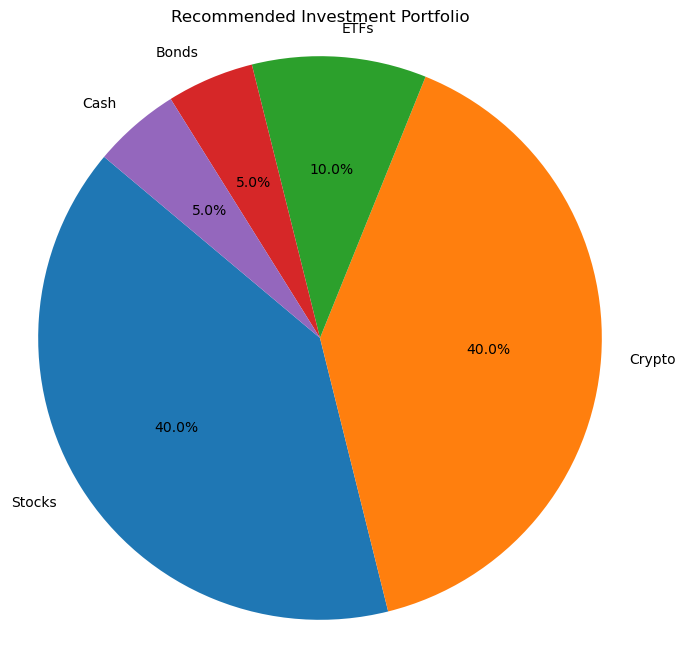

In [36]:
import matplotlib.pyplot as plt
import numpy as np


# Example diversified portfolio for different risk levels (1: Conservative, 5: Aggressive)
portfolio_distribution = {
    1: {
        'ETFs': 60,
        'Bonds': 30,
        'Cash': 10
    },
    2: {
        'ETFs': 50,
        'Bonds': 30,
        'Stocks': 10,
        'Crypto': 10
    },
    3: {
        'ETFs': 40,
        'Bonds': 20,
        'Stocks': 20,
        'Crypto': 20
    },
    4: {
        'ETFs': 30,
        'Stocks': 30,
        'Crypto': 20,
        'Real Estate': 10,
        'Bonds': 10
    },
    5: {
        'Stocks': 40,
        'Crypto': 40,
        'ETFs': 10,
        'Bonds': 5,
        'Cash': 5
    }
}

# Function to classify the user's risk tolerance based on score
def calculate_risk_level(total_score):
    if total_score <= 9:
        return 1  # Risk-averse
    elif 10 <= total_score <= 14:
        return 2  # Low Risk Tolerance
    elif 15 <= total_score <= 19:
        return 3  # Moderate Risk Tolerance
    elif 20 <= total_score <= 24:
        return 4  # High Risk Tolerance
    else:
        return 5  # Very High Risk Tolerance

# Function to recommend a portfolio based on the risk level (market interests removed)
def recommend_portfolio(risk_level):
    # Basic asset distribution for the selected risk level
    portfolio = portfolio_distribution[risk_level]
    
    # Normalize the portfolio to ensure it sums to 100
    total_percentage = sum(portfolio.values())
    normalized_portfolio = {key: value / total_percentage * 100 for key, value in portfolio.items()}
    
    return normalized_portfolio

# Function to visualize the portfolio
def visualize_portfolio(portfolio):
    labels = portfolio.keys()
    sizes = portfolio.values()
    
    # Plotting the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Recommended Investment Portfolio')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
    plt.show()

# Function to interact with the user and evaluate responses
def chat_with_user():
    print("Welcome to the Investor Risk Tolerance Chatbot!\n")
    total_score = 0

    # Ask risk tolerance questions (Assuming `questions` is predefined)
    for question in questions:
        print(question)
        response = input("Your answer: ")
        score = classify_risk_tolerance(response)
        total_score += score
        print(f"Your response has been scored: {score} (Risk Tolerance Level)")

    # Calculate risk level
    risk_level = calculate_risk_level(total_score)
    print(f"\nYour risk tolerance level is: {risk_level}")

    # Recommend portfolio based on the risk level
    portfolio = recommend_portfolio(risk_level)

    # Display the portfolio
    print("\nYour recommended portfolio is:")
    for asset, allocation in portfolio.items():
        print(f"{asset}: {allocation:.2f}%")
    
    # Visualize the portfolio as a pie chart
    visualize_portfolio(portfolio)

# Run the chatbot
if __name__ == "__main__":
    chat_with_user()
